# Titanic Survivor Prediction

In [658]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

## Definitions

In [659]:
p_class = {
    1: '1st Upper',
    2: '2st Middle',
    3: '3st Lower',
}

harbor = {
    'S': 'Southampton',
    'C': 'Cherbourg',
    'Q': 'Queenstown',
}


## Load Data

In [660]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Handle outliers and missing data

In [661]:
print(f" There is {train_df['Age'].isnull().value_counts().get(True)} passangers with no age information in the training set")
print(f" There is {train_df['Cabin'].isnull().value_counts().get(True)} passangers with no cabin information in the training set")
print(f" There is {train_df['Embarked'].isnull().value_counts().get(True)} passangers with no embarked information in the training set")
print(f" There is {train_df['Fare'].isnull().value_counts().get(True)} passangers with no fare information in the training set")

print(f" There is {test_df['Age'].isnull().value_counts().get(True)} passangers with no age information in the test set")
print(f" There is {test_df['Cabin'].isnull().value_counts().get(True)} passangers with no cabin information in the test set")
print(f" There is {test_df['Embarked'].isnull().value_counts().get(True)} passangers with no embarked information in the test set")
print(f" There is {test_df['Fare'].isnull().value_counts().get(True)} passangers with no fare information in the test set")

 There is 177 passangers with no age information in the training set
 There is 687 passangers with no cabin information in the training set
 There is 2 passangers with no embarked information in the training set
 There is None passangers with no fare information in the training set
 There is 86 passangers with no age information in the test set
 There is 327 passangers with no cabin information in the test set
 There is None passangers with no embarked information in the test set
 There is 1 passangers with no fare information in the test set


In [662]:
# Fill missing age with mean
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)

# Drop cabin because 77.7% of the data is missing this information
train_df.drop('Cabin', axis=1, inplace=True)

# Fill missing embarked with most common
train_df['Embarked'].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)

# Replace Fare outliers with mean
train_df['Fare'] = np.where(train_df['Fare'] > 300, train_df['Fare'].mean(), train_df['Fare'])

In [663]:
# Fill missing age with mean
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

# Drop cabin because 77.7% of the data is missing this information
test_df.drop('Cabin', axis=1, inplace=True)

# Replace Fare outliers with mean
test_df['Fare'] = np.where(test_df['Fare'] > 300, test_df['Fare'].mean(), test_df['Fare'])
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

## Data Visualization

<Axes: xlabel='Survived', ylabel='count'>

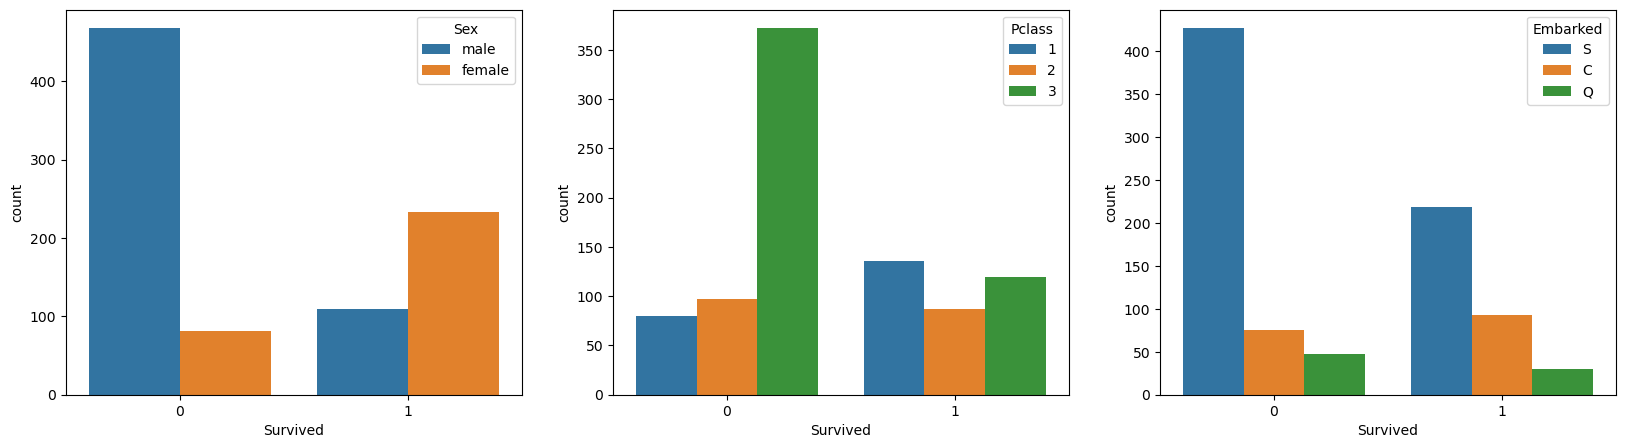

In [664]:
# Survived relation with Pclass,sex and harbor

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

sns.countplot(x='Survived', hue='Sex', data=train_df, ax=axes[0])
sns.countplot(x='Survived', hue='Pclass', data=train_df, ax=axes[1])
sns.countplot(x='Survived', hue='Embarked', data=train_df, ax=axes[2])


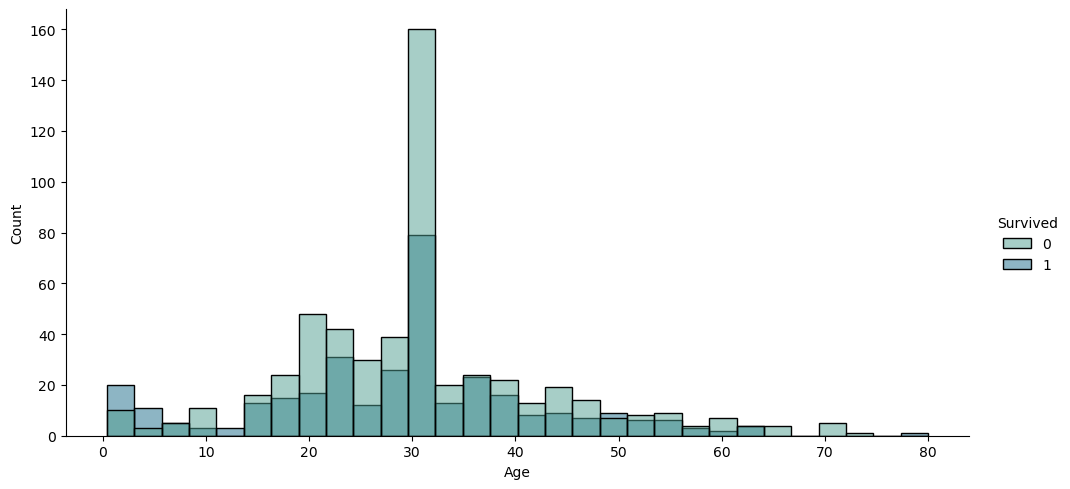

In [665]:
sns.displot(x='Age', hue='Survived', data=train_df, kind='hist', fill=True, palette='crest', height=5, aspect=2)

<Axes: xlabel='Survived', ylabel='Fare'>

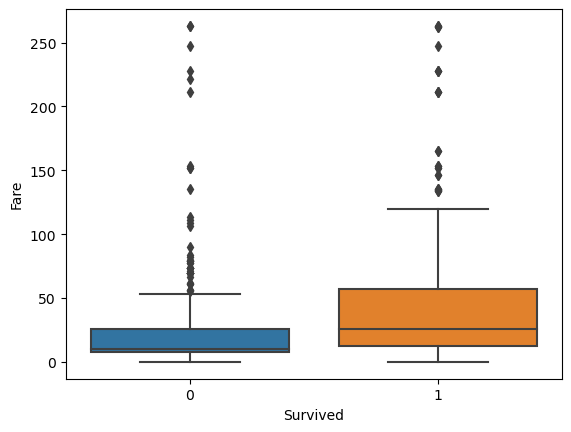

In [666]:
sns.boxplot(x='Survived', y='Fare', data=train_df)

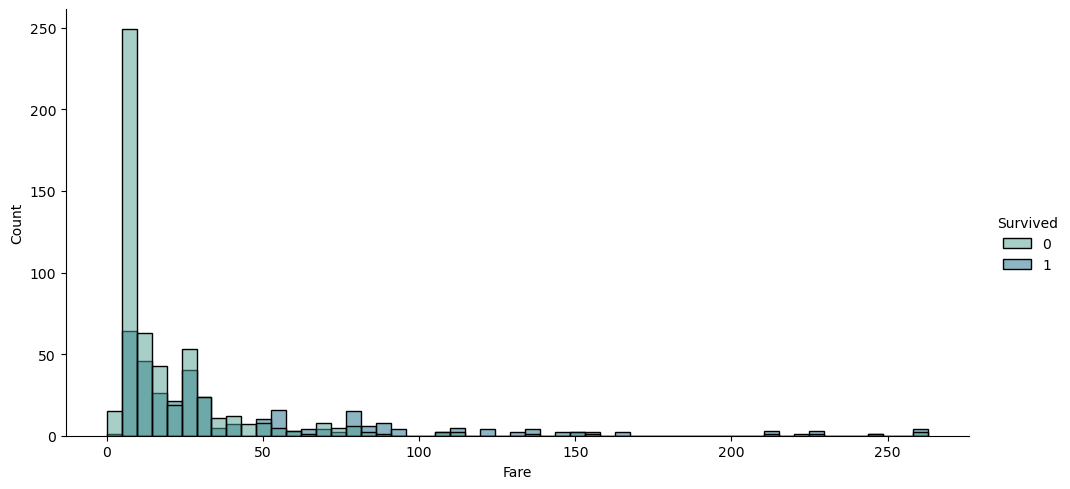

In [667]:
sns.displot(x='Fare', hue='Survived', data=train_df, kind='hist', palette='crest', height=5, aspect=2)

<Axes: xlabel='Fare', ylabel='Count'>

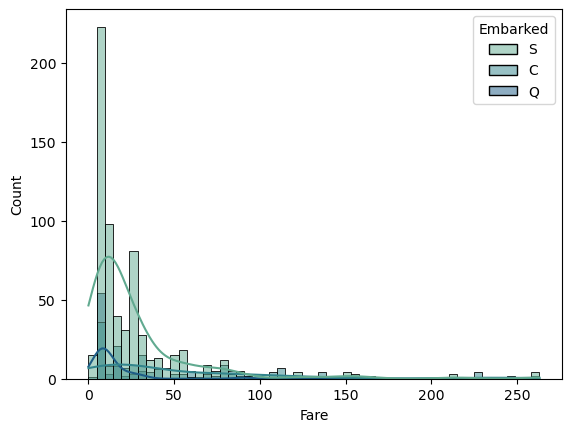

In [668]:
sns.histplot(x='Fare', hue='Embarked', data=train_df, kde=True, palette='crest')

<Axes: xlabel='Age', ylabel='Fare'>

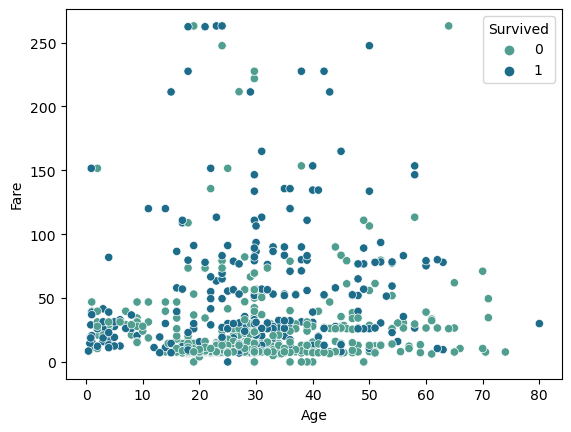

In [669]:
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_df, palette='crest')

## Feature Scaling

In [670]:
def normalization(df, column_names):
    """Normalization of the given columns in the dataframe
        
        Method in which data points are shifted and rescaled so
        that they end up in a range of 0 to 1.
        It is also known as min-max scaling.

        Normalization is preferred over standardization when our data doesnt 
        follow a normal distribution. It can be useful in those machine learning
        algorithms that do not assume any distribution of data like the k-nearest neighbor and neural networks.
    """
    for column_name in column_names:
        df[column_name] = (df[column_name] - df[column_name].mean()) / (df[column_name].max() - df[column_name].min())
    return df

def z_norm(df, column_names):
    """ Standardization of the given columns in the dataframe
        
        Method where the values are centered around mean with a unit standard deviation.
        It means if we will calculate mean and standard deviation of standard scores it will be 0 and 1 respectively.

        z = (x - u) / s

        where:
            x = value
            u = mean
            s = standard deviation
        
        It is also known as z-score normalization.

        i.e. If Z=2, it means that the observation lies two standard deviations above the mean.

        Standardization is good to use when our data follows a normal distribution. 
        It can be used in a machine learning algorithm where we make assumptions about the distribution of data like linear regression etc
    """
    for column_name in column_names:
        df[column_name] = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    return df

train_df=z_norm(train_df, ['Age', 'Fare'])

## Handle Categorical Data - One Hot Encoding

In [671]:
# One hot encoding

## TODO: Study the colinearity and correlation of the features
## Drop the features that are highly correlated and keep the ones that are not
## Apply one hot encoding to the categorical features

## Split Dataset

Let's get the train set and split it into 80/20 for train and validation

In [672]:
train_df_split, val_df_split = train_test_split(train_df, test_size=0.2, random_state=42)

x_train = train_df_split.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'SibSp', 	'Parch', 'Embarked', 'Sex'], axis=1)
y_train = train_df_split['Survived']

x_val= val_df_split.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'SibSp', 	'Parch', 'Embarked', 'Sex'], axis=1)
y_val= val_df_split['Survived']

In [673]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a linear regression model
baseline = LinearRegression()

# train baseline model
baseline.fit(x_train, y_train)

# Get the slope and intercept of the line best fit.
print(f"Intercept: {baseline.intercept_}")
print(f"Slope: {baseline.coef_}")

predictions = baseline.predict(x_val)

# The mean squared error
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_val, predictions))
# The coefficient of determination: 1 is perfect prediction
print("R2 Score: %.2f" % r2_score(y_val, predictions))

Intercept: 0.8483542243077598
Slope: [-0.20297993 -0.08238095  0.02449909]
Mean squared error (MSE): 0.19
R2 Score: 0.22
